# Comparing Models with Bayesian Evidence and Information Criteria

## Introduction

We'll be looking at some fake but realistic data and comparing how well different models do at describing it.

It's a simple data set, just a list of numbers. Each one represents a measured distance between two different estimates of the center of a galaxy cluster: the location of the brightest galaxy and a centroid of the emissive, diffuse gas. The context here is that automated algorithms sometimes fail to chose the central galaxy correctly (because of image artifacts or other problems), whereas the gas centroid is more reliable but also more expensive to measure. Therefore, we'd like to use this data set to characterize the distribution of mis-centerings so that the galaxy-based centers can be used for large sample, with the resulting errors propagated forward through future processing, e.g., weak lensing estimates.

Let's load up the data and have a look.

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
%matplotlib inline
# or %matplotlib notebook

In [2]:
y = np.loadtxt('model_evaluation.dat')

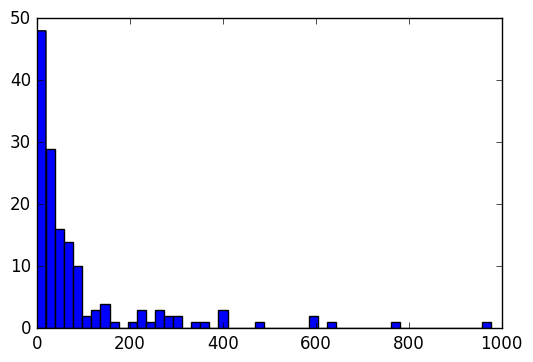

In [3]:
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.hist(y, bins=50);

## Problem 1: evaluating a simple model

First, let's fit and evaluate a simple model for the data. I propose the exponential distribution, but feel free to use a different guess.

**Model 1:** $P(y|x_1) = \frac{1}{x_1}e^{-y/x_1}$; $y\geq0$

#### 1a) Select a prior distribution for Model 1.

Make sure it's a proper (normalizable) distribution. We don't want to deal with improper distributions when calculating the evidence later on.

For e.g., to adopt a uniform prior, you could just use statements like the ones below, with appropriate implementation of later functions:

In [4]:
x1_lo = 0.0 # lower bound
x1_hi = 500.0 # upper bound

#### 1b) Implement likelihood, posterior, and predictive functions for Model 1.

This code should get you started.

In [5]:
# Log-likelihood function
def lli1(x1):
    # uses global 'y' variable where the data are stored
    # x1 is a scalar
    return np.sum(st.expon.logpdf(y, scale=x1))

# For convenience. This function can be called with a vector argument, unlike lli1.
loglike1 = np.vectorize(lli1)

# Log-posterior function. We'll use this with an MCMC sampler, so it should call the non-vectorized likelihood.
def post1(p):
    x1 = p[0]
    if x1 < x1_lo or x1 > x1_hi: return -np.inf
    like = lli1(x1)
    return like

# Posterior-predictive density
def postpredpdf1(yy, x1):
    return st.expon.pdf(yy, scale=x1)

# Perform posterior prediction
def postpred1(n, x1):
    # return n mock data points from the model
    return st.expon.rvs(scale=x1, size=n)

#### 1c) Fit Model 1.

Code below will do parameter inference, look at the resulting Markov chains, remove burn-in, thin, and concatenate chains. Since this step isn't really the point of this problem, it's mostly given, but you'll still need to fill in a few pieces.

In [6]:
import emcee

Set up the sampling problem.

In [7]:
nwalkers = 100
ndim = 1
lnprob = post1
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)

Define starting points for each chain in the ensemble. Given a guess at the right answer, this code initializes them to be at the guess $\pm$ a percent or so. For later, note that this array should have dimensions `Nwalkers` $\times$ `Nparameters`.

In [8]:
theta1_0 = np.array([[70.0]*(1.0 + 0.01*np.random.rand(ndim)) for j in range(nwalkers)])
theta1_0.shape

(100, 1)

Run the sampler and look at the resulting chains.

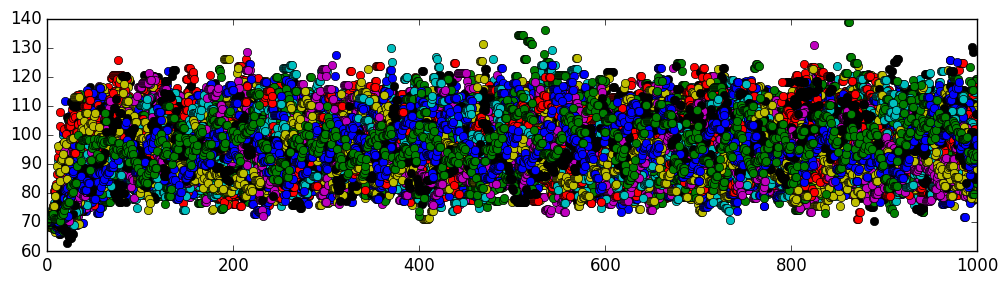

In [9]:
sampler.run_mcmc(theta1_0, 1000)
ens1 = sampler.chain
plt.rcParams['figure.figsize'] = (12.0, 3.0)
for j in range(nwalkers): plt.plot(ens1[j,:,0], 'o');

Remove obvious burn-in and do some thinning.

In [11]:
burn = 100
thinby = 5
samples1 = ens1[:, burn:, :].reshape((-1, ndim))
samples1 = samples1[range(0,samples1.shape[0],thinby),:]
samples1.shape

(18000, 1)

It will be useful for later to know the mean of the posterior.

In [12]:
postmean1 = np.mean(samples1[:,0])
postmean1

96.082665304148776

#### 1d) Visually compare the predictions of Model 1 with the data.

First, let's just plot the posterior-mean model over the data.

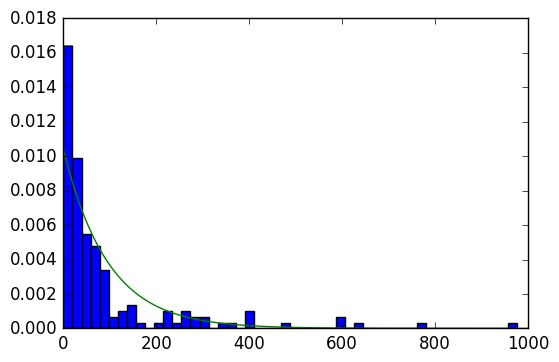

In [13]:
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.hist(y, bins=50, normed=True)
yy = np.arange(1000.)
plt.plot(yy, postpredpdf1(yy, postmean1));

Now, let's compare a random predicted data set from the posterior with the data.

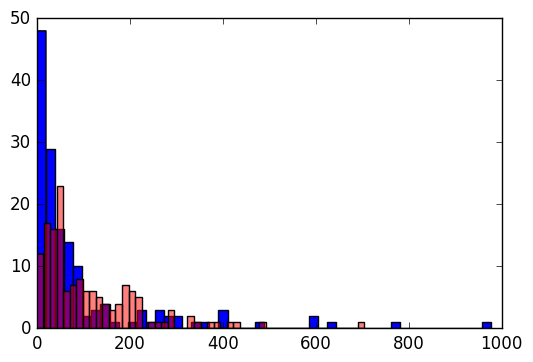

In [67]:
j = 100 # arbitrary posterior sample
mock = postpred1(len(y), samples1[j,0])
plt.hist(y, bins=50)
plt.hist(mock, bins=50, color=[1,0,0,0.5]);

Qualitatively, would you say the model is a good fit?

#### 1e) Choose a simple test statistic and use it to compare the data with the posterior predictive distribution.

Do this visually, as well as calculating the corresponding $p$-value.

In [37]:
# T is the number of offsets >100, for no good reason
def T(yy):
    return np.where(yy > 100)[0].shape[0]
pp = np.array([T(postpred1(len(y), x1)) for x1 in samples1[:,0]])

32 0.997722222222


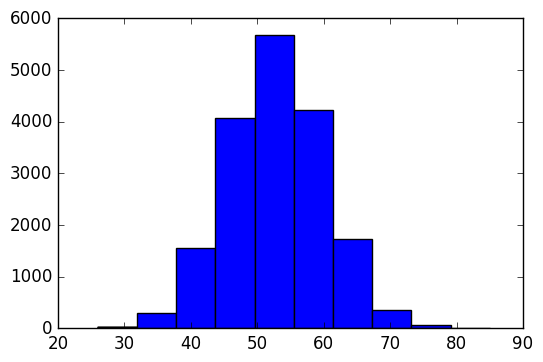

In [43]:
plt.hist(pp);
print T(y), float(np.where(pp > T(y))[0].shape[0])/len(pp)

Does the quantitative goodness-of-fit match your expectation?

#### 1f) Calculate the DIC for Model 1.

Also compute the value of $p_D$. (Does it make sense?) We'll compare these to the corresponding values for a different model later.

In [44]:
Dbar = -2.0 * np.mean(loglike1(samples1[:,0]))
Dhat = -2.0 * loglike1(postmean1)
pD = Dbar - Dhat
DIC1 = Dbar + pD
print Dbar, Dhat, pD, DIC1

1666.95725681 1665.94894719 1.00830961772 1667.96556643


#### 1g) Compute the evidence for Model 1.

To do this, note that

$P(D|H)=\int P(D|\theta,H) \, P(\theta|H) d\theta$

can be approximated by an average over samples from the prior

$P(D|H) \approx \sum_{k=1}^m P(D|\theta_k,H)$; $\theta_k\sim P(\theta|H)$.

This approach is not especially efficient or numerically stable in general (because the likelihood typically is large in only a small fraction of the prior volume), but it will do for this exercise.

Draw a large number of samples ($m$) from the prior and use them to calculate the evidence. In fact, to avoid numerical over/underflows, we'll need to add a constant to the log-likelihoods before exponentiating them in the average. To compare evidences from 2 models, we'll of course need to add the *same* constant in each case. Nevertheless, it's worth putting together the machinery to do these calculations now.

In [49]:
nmc = 10000
x1_from_prior = np.random.uniform(x1_lo, x1_hi, nmc)
ll_from_prior1 = loglike1(x1_from_prior)

m = np.max(ll_from_prior1)
print np.mean(np.exp(ll_from_prior1 - m))

0.0386894236658


## Problem 2: evaluating a more complex model

Choose a more complex model to compare to Model 1. I suggest incorporating another standard PDF (implemented in `scipy`) into the likelihood, with a parameter indicating the relative proportion of the two components, such that

$P(y|\theta_1,\theta_2,f) = f\,P_1(y|\theta_1) + (1-f)\,P_2(y|\theta_2)$.

But feel free to do something different if you like.

Next, repeat the various fitting and evaluating steps that we did for Model 1 for this new model.

#### 2a) Specify Model 2, and a choose sensible prior distribution.

If following the hint above, don't forget that $f$ is also a parameter of the model!

In [45]:
frac_lo = 0.0
frac_hi = 1.0
x2_lo = 0.0
x2_hi = 500.0

#### 2b) Implement likelihood, posterior, and predictive functions for Model 2.

In [65]:
# Log-likelihood function
def lli2(x1, x2, frac):
    return np.sum(np.log(frac*st.expon.pdf(y, scale=x1) + (1.0-frac)*st.gamma.pdf(y/x2,2.0)/x2))

# For convenience. This function can be called with a vector argument, unlike lli2.
loglike2 = np.vectorize(lli2)

# Log-posterior function. We'll use this with an MCMC sampler, so it should call the non-vectorized likelihood.
def post2(p):
    x1 = p[0]
    x2 = p[1]
    frac = p[2]
    if x1 < x1_lo or x1 > x1_hi or x2 < x2_lo or x2 > x2_hi or frac < frac_lo or frac > frac_hi: return -np.inf
    return lli2(x1, x2, frac)

# Posterior-predictive density
def postpredpdf2(yy, x1, x2, frac):
    return frac*st.expon.pdf(yy, scale=x1) + (1.0-frac)*st.gamma.pdf(yy/x2,2.0)/x2

# Perform posterior prediction
def postpred2(n, x1, x2, frac):
    # return n mock data points from the model
    y1 = st.expon.rvs(scale=x1, size=n)
    y2 = st.gamma.rvs(2.0, size=n) * x2
    r = np.random.sample(n)
    return np.concatenate((y1[np.where(r <= frac)], y2[np.where(r > frac)]))

#### 2c) Fit Model 2.

The code above should still work, with relatively minor changes.

In [50]:
nwalkers = 100
ndim = 3
lnprob = post2
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=4)

In [51]:
theta2_0 = np.array([[30.0, 150.0, 0.7]*(1.0 + 0.01*np.random.rand(ndim)) for j in range(nwalkers)])
theta2_0.shape

(100, 3)

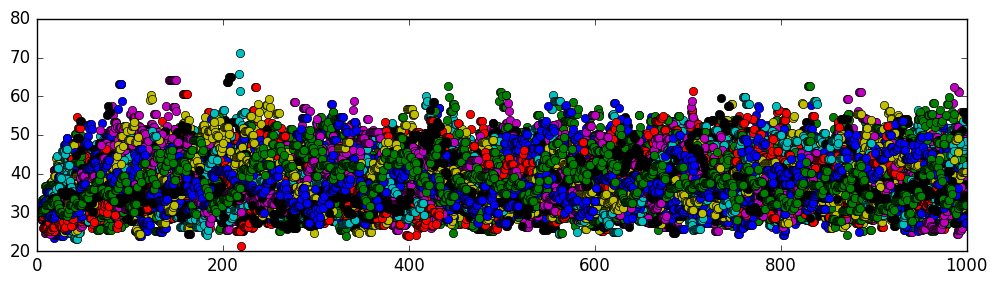

In [52]:
sampler.run_mcmc(theta2_0, 1000)
ens2 = sampler.chain
plt.rcParams['figure.figsize'] = (12.0, 3.0)
for j in range(nwalkers): plt.plot(ens2[j,:,0], 'o');

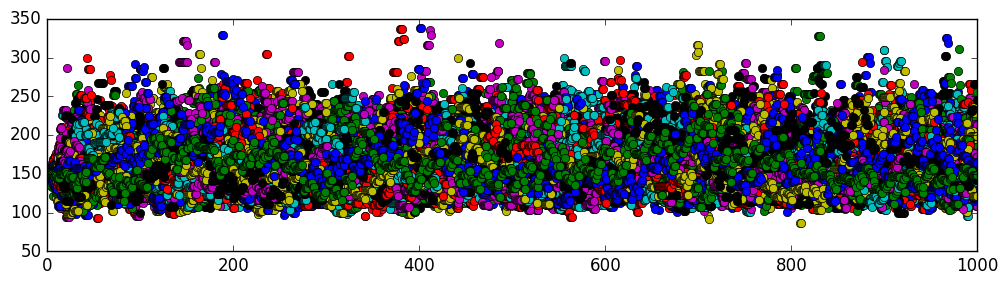

In [53]:
for j in range(nwalkers): plt.plot(ens2[j,:,1], 'o');

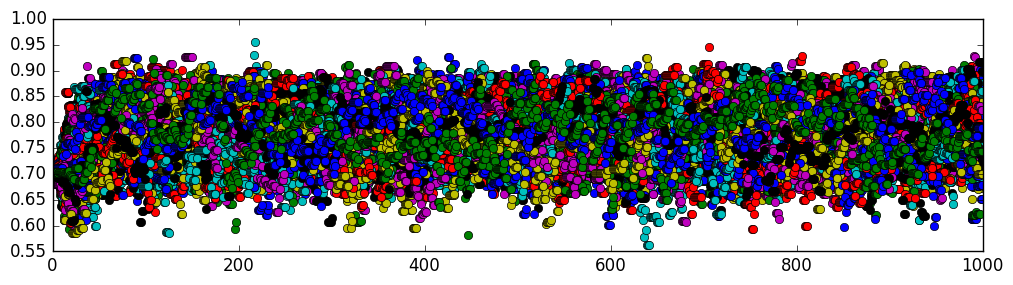

In [54]:
for j in range(nwalkers): plt.plot(ens2[j,:,2], 'o');

In [55]:
burn = 100
thinby = 5
samples2 = ens2[:, burn:, :].reshape((-1, ndim))
samples2 = samples2[range(0,samples2.shape[0],thinby),:]
samples2.shape

(18000, 3)

In [57]:
postmean2 = np.array([np.mean(samples2[:,0]), np.mean(samples2[:,1]), np.mean(samples2[:,2])])
postmean2

array([  38.03383677,  163.95013203,    0.78678136])

#### 2d) Visually compare the predictions of Model 2 with the data.

Do the same quantitative posterior predicive test as before, also. Does the new model fit the data better?

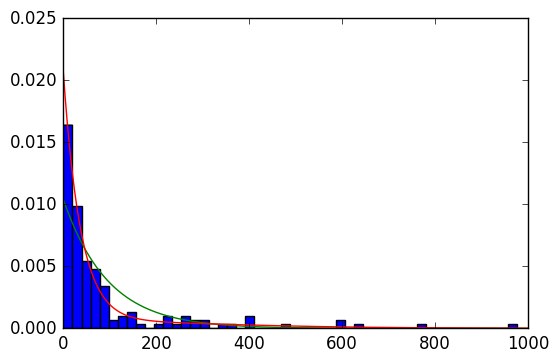

In [63]:
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.hist(y, bins=50, normed=True)
yy = np.arange(1000.)
plt.plot(yy, postpredpdf1(yy, postmean1));
plt.plot(yy, postpredpdf2(yy, postmean2[0], postmean2[1], postmean2[2]));

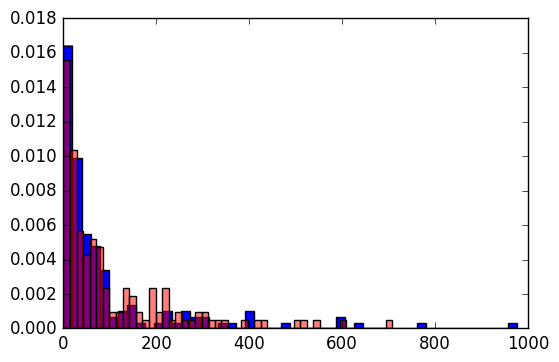

In [68]:
j = 100
mock = postpred2(len(y), samples2[j,0], samples2[j,1], samples2[j,2])
plt.hist(y, bins=50, normed=True)
plt.hist(mock, bins=50, normed=True, color=[1,0,0,0.5]);

#### 2e) Compare the data with the posterior predictive distribution of your test statistic for Model 2.

32 0.649277777778


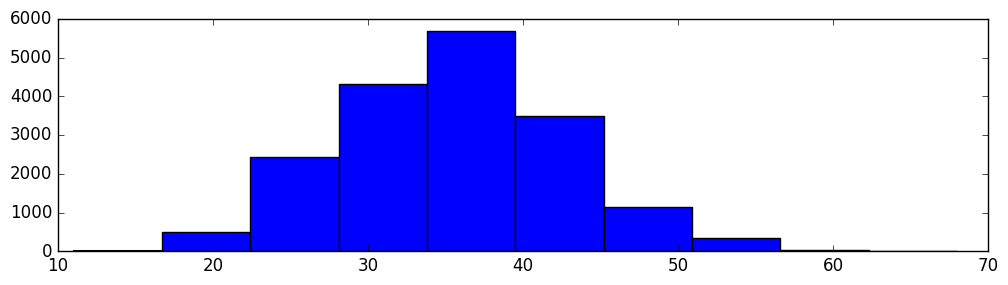

In [59]:
pp = np.array([T(postpred2(len(y), x1, x2, frac)) for x1,x2,frac in samples2])
plt.hist(pp);
print T(y), float(np.where(pp > T(y))[0].shape[0])/len(pp)

#### 2f) Calculate the DIC and $p_D$ for Model 2.

In [69]:
Dbar = -2.0 * np.mean(loglike2(samples2[:,0], samples2[:,1], samples2[:,2]))
Dhat = -2.0 * loglike2(postmean2[0], postmean2[1], postmean2[2])
pD = Dbar - Dhat
DIC2 = Dbar + pD
print Dbar, Dhat, pD, DIC1

1616.71594271 1613.82760818 2.88833453137 1667.96556643


#### 2g) Compute the evidence for Model 2.

As before.

In [70]:
# reuse x1_from_prior
x2_from_prior = np.random.uniform(x2_lo, x2_hi, nmc)
frac_from_prior = np.random.uniform(frac_lo, frac_hi, nmc)
ll_from_prior2 = loglike2(x1_from_prior, x2_from_prior, frac_from_prior)

m = np.max(ll_from_prior2)
print np.mean(np.exp(ll_from_prior2 - m))

0.00071443859763


## Problem 3: compare models

#### 3a) Use the difference in DIC between models 1 and 2 to conclude something about the relative fitness of the two models.

In [71]:
print DIC2 - DIC1

-48.3612891873


#### 3b) Use the evidence ratio of the two models to conclude something about their relative probability.

You'll need to re-calculate the evidences in this step. As before, the log-likelihoods will need to be offset by a constant to avoid numerical over/underflows, but of course the *same* offset needs to be applied to each model.

In [76]:
m = np.max([np.max(ll_from_prior1), np.max(ll_from_prior2)])
logevidence1 = np.log(np.mean(np.exp(ll_from_prior1 - m)))
logevidence2 = np.log(np.mean(np.exp(ll_from_prior2 - m)))
print logevidence1, logevidence2, logevidence2-logevidence1, np.exp(logevidence2-logevidence1)

-28.7556122941 -7.24401350182 21.5115987922 2199726325.87


## Challenge problem

Use `emcee`'s parallel tempering functionality to calculate the log-evidences for the two models above (see the [documentation](http://dan.iel.fm/emcee/current/user/pt/)). Compare the difference in log-evidence with what you found above.

## Mega-Challenge problem

[This notebook](challenge_thermo_integ.ipynb) provides the opportunity to delve into thermodynamic integration as a method of computing the evidence (this is what `emcee` does in the challenge problem above) in more detail, to see how and why it works.